In [1]:
import math
import joblib
import keras

import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras import activations, layers, initializers
from keras.models import Model
from keras.optimizers.legacy import Adam

from src.inn_layers_v2 import IntAdd, IntDense, IntConv2D, IntDropout, IntFlatten, IntMultiply, IntSilu, IntGelu
from src.inn_layers_v2 import IntZeroPadding2D, IntBatchNormalization, IntRelu, IntTanh, IntMultiply_donet
from src.wrapper import trainer

from matplotlib import pyplot as plt
import matplotlib.patches as patches
from src import inn_layers_v2 as innv2
from src import grid_augmentation as ga

import scienceplots
plt.style.use('science')

import warnings
warnings.filterwarnings("ignore")


In [2]:
params = {'xtick.labelsize':12,
          'ytick.labelsize':12,
          'axes.labelsize': 16,
          'axes.titlesize': 18}
plt.rcParams.update(params)

In [3]:
def func1(x, noise_scale=0.05):
    eps = np.random.normal(0, noise_scale, x.shape[0])
    return np.sin(2 * np.pi * x**2) * np.exp(-x) + 1 + eps

def interval_input(x, min_width, max_width):
    radii = np.random.uniform(min_width,max_width,size=x.shape[0])/2
    x_lo = x - radii
    x_hi = x + radii

    return x_lo, x_hi

def interval_propagation(x_int, noise=0):
    y_int = []
    for x_i in tqdm(x_int):
        samp = np.linspace(x_i[0], x_i[1], 100)
        y_samp = func1(samp, noise_scale=noise)
        y_lo = np.min(y_samp)
        y_hi = np.max(y_samp)
        y_i = np.array([y_lo,y_hi])
        y_int.append(y_i)
    y_int = np.array(y_int)
    return y_int
        

In [4]:
### Create pointwise data ###
x_points = np.linspace(0,1,500)
y_noiseless = func1(x_points, noise_scale=0.0)
y_points = func1(x_points, noise_scale=0.025)

# Choose 50 random as training data
np.random.seed(17)
x_train = np.random.choice(x_points, size=50, replace=False)
y_train = func1(x_train, noise_scale=0.025)

In [5]:
### Construct interval TEST data ###
x_lo,x_hi = interval_input(x_points, min_width=0.015, max_width=0.075)
x_int = np.stack([x_lo.T, x_hi.T], axis=1)
y_int = interval_propagation(x_int, noise=0.025)
y_int_noiseless = interval_propagation(x_int, noise=0)

100%|██████████| 500/500 [00:00<00:00, 42567.07it/s]


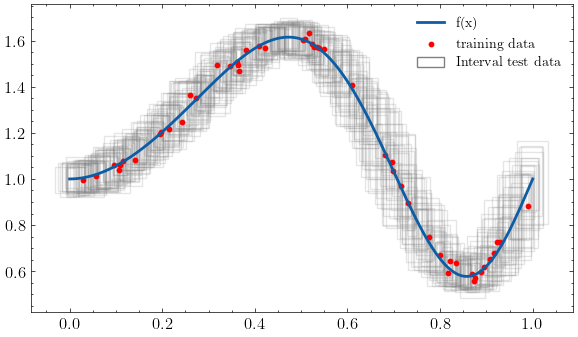

In [6]:
# Plot
fig, ax = plt.subplots(figsize=(7, 4))

for i in range(len(x_int)):
    x_lo, x_hi = x_int[i]
    y_lo, y_hi = y_int[i]
    width = x_hi - x_lo
    height = y_hi - y_lo
    rect = patches.Rectangle((x_lo, y_lo), width, height,
                             linewidth=1, edgecolor='grey', facecolor='none', alpha=0.2)
    ax.add_patch(rect)

rect_legend = patches.Patch(edgecolor='grey', facecolor='none', label='interval test')
line = ax.plot(x_points,y_noiseless,linewidth=2, label="f(x)")
scatter = ax.scatter(x_train,y_train, s=10, c="red", label="training data")

# Get existing handles and labels
handles, labels = ax.get_legend_handles_labels()

# Append custom rectangle legend
handles.append(rect_legend)
labels.append('Interval test data')

# Add final legend
ax.legend(handles=handles, labels=labels)

plt.show()

## Grid Augmentation

In [7]:
np.linspace(0.05,0.35,9)

array([0.05  , 0.0875, 0.125 , 0.1625, 0.2   , 0.2375, 0.275 , 0.3125,
       0.35  ])

In [8]:
grid_res = [[a] for a in np.linspace(0.05,0.35,9)]
x_train_int, y_train_int = ga.construct_interval_grid(x_train, y_train, 
                                                     grid_res=grid_res, n_shift=3, nmax_per_res=25)

100%|██████████| 9/9 [00:00<00:00, 872.68it/s]

Grid resolution [0.05] has 25 data
Grid resolution [0.0875] has 25 data
Grid resolution [0.125] has 24 data
Grid resolution [0.16249999999999998] has 19 data
Grid resolution [0.2] has 16 data
Grid resolution [0.2375] has 14 data
Grid resolution [0.27499999999999997] has 13 data
Grid resolution [0.3125] has 11 data
Grid resolution [0.35] has 10 data


In [9]:
x_train_int.shape

(157, 1, 2)

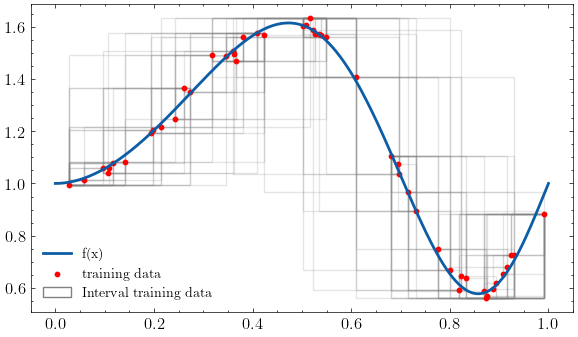

In [10]:
fig, ax = plt.subplots(figsize=(7, 4))

for i in range(len(x_train_int)):
    x_lo, x_hi = x_train_int[i,0]
    y_lo, y_hi = y_train_int[i,0]
    width = x_hi - x_lo
    height = y_hi - y_lo
    rect = patches.Rectangle((x_lo, y_lo), width, height,
                             linewidth=1, edgecolor='grey', facecolor='none', alpha=0.2)
    ax.add_patch(rect)

rect_legend = patches.Patch(edgecolor='grey', facecolor='none', label='interval test')
line = ax.plot(x_points,y_noiseless,linewidth=2, label="f(x)")
scatter = ax.scatter(x_train,y_train, s=10, c="red", label="training data")

# Get existing handles and labels
handles, labels = ax.get_legend_handles_labels()

# Append custom rectangle legend
handles.append(rect_legend)
labels.append('Interval training data')

# Add final legend
ax.legend(handles=handles, labels=labels)

plt.show()

## IMLP

In [11]:
def imlp(input_shape, hidden_layers=[32,64,32], output_size=1):
    """interval multilayer perceptron constructor

    Args:
        input_shape (_type_): _description_
        n_hidden_layers (int, optional): Number of hidden layers. Defaults to 1.
    """

    assert type(hidden_layers) == list , "Hidden layers should be a list."
    assert type(output_size) == int and output_size > 0, "Output size should be an integer and greater than 0"

    # Input layers
    inputs = [keras.Input(input_shape), keras.Input(input_shape)]

    # MLP hidden layers
    for idx,n_layers in enumerate(hidden_layers):
        if idx == 0:
            x = innv2.IntDense(n_layers, activation=None)(inputs)
        else:
            x = innv2.IntDense(n_layers, activation=None)(x)

        x = innv2.IntSilu()(x)
    
    # MLP output layers
    outputs = innv2.IntDense(output_size, activation=None)(x)

    model = keras.Model(inputs, outputs, name="IntervalMLP")

    return model

In [12]:
inn = imlp(input_shape=(1,), hidden_layers=[16,16,16], output_size=1)

2025-08-09 17:25:06.929032: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-08-09 17:25:06.929058: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-08-09 17:25:06.929085: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-08-09 17:25:06.929120: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-09 17:25:06.929134: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
y_train_int.shape

(157, 1, 2)

In [14]:
def run_experiment(model, x_int_train, y_int_train, x_int_test, y_int_test, 
                   repetitions=10, n_train = 50, epochs=1000, verbose=0):
    """Run the experiment with the given model and data."""
    
    # Compile model
    model.compile(optimizer=Adam(learning_rate=1e-2))

    results = []

    # Choose n_train random as training data
    for seed in tqdm(range(repetitions)):
        data = dict()
        np.random.seed(seed)
        idx = np.random.choice(np.arange(x_int_train.shape[0]), size=n_train, replace=False)
        x_train_int = x_int_train[idx]
        y_train_int = y_int_train[idx]   

        # Train model
        model,hist = trainer(inn, x_train_int, y_train_int, epochs=epochs, linex_a=5, loss_type="linex", verbose=verbose)

        # Evaluate model
        pred = model.predict([x_int_test[...,0][...,None], x_int_test[...,1][...,None]])
        data["x_train"] = x_train_int
        data["y_train"] = y_train_int
        data["x_test"] = x_int_test
        data["y_test"] = y_int_test
        data["pred"] = pred
        data["history"] = hist

        results.append(data)
        
    return results

In [15]:
results = run_experiment(inn, x_train_int, y_train_int, x_int, y_int, 
                         repetitions=10, n_train=50, epochs=3000, verbose=False)
joblib.dump(results, "output/simple1dreg_aug_inn_ntrain50.pkl")

  0%|          | 0/10 [00:00<?, ?it/s]

 1/16 [>.............................] - ETA: 3s

2025-08-09 17:29:24.605057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 9ms/step


 10%|█         | 1/10 [04:17<38:37, 257.52s/it]

16/16 [==============================] - 0s 6ms/step


 20%|██        | 2/10 [08:37<34:30, 258.79s/it]

16/16 [==============================] - 0s 6ms/step


 30%|███       | 3/10 [12:58<30:20, 260.01s/it]

16/16 [==============================] - 0s 5ms/step


 40%|████      | 4/10 [17:11<25:42, 257.05s/it]

16/16 [==============================] - 0s 6ms/step


 50%|█████     | 5/10 [21:22<21:14, 254.95s/it]

16/16 [==============================] - 0s 5ms/step


 60%|██████    | 6/10 [25:33<16:55, 253.77s/it]

16/16 [==============================] - 0s 6ms/step


 70%|███████   | 7/10 [29:56<12:49, 256.64s/it]

16/16 [==============================] - 0s 14ms/step


 80%|████████  | 8/10 [34:12<08:33, 256.58s/it]

16/16 [==============================] - 0s 7ms/step


 90%|█████████ | 9/10 [38:25<04:15, 255.28s/it]

16/16 [==============================] - 0s 5ms/step


100%|██████████| 10/10 [42:31<00:00, 255.20s/it]


['output/simple1dreg_aug_inn_ntrain50.pkl']

Inverted predicted interval count: 0/500


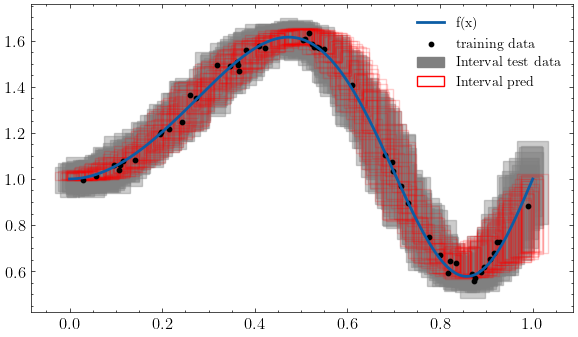

In [16]:
id = 0 # Experiment ID
fig, ax = plt.subplots(figsize=(7, 4))

data = results[id]
x_train_int = data["x_train"]
y_train_int = data["y_train"]
x_test_int = data["x_test"]
y_test_int = data["y_test"]
pred = data["pred"]
history = data["history"]

for i in range(len(x_int)):
    x_lo, x_hi = x_int[i]
    y_lo, y_hi = y_int[i]
    width = x_hi - x_lo
    height = y_hi - y_lo
    rect = patches.Rectangle((x_lo, y_lo), width, height,
                             linewidth=1, edgecolor='grey', facecolor='grey', alpha=0.4)
    ax.add_patch(rect)

inverted_count = 0
for i in range(len(x_int)):
    x_lo, x_hi = x_int[i]
    width = x_hi - x_lo
    height2 = pred[1][i] - pred[0][i]
    if height2 < 0:
        inverted_count += 1
    rect2 = patches.Rectangle((x_lo, pred[0][i]), width, height2,
                             linewidth=1, edgecolor='red', facecolor='none', alpha=0.2)
    ax.add_patch(rect2)

print(f"Inverted predicted interval count: {inverted_count}/{len(x_int)}")
rect_legend = patches.Patch(edgecolor='grey', facecolor='grey', label='interval test')
rect_legend2 = patches.Patch(edgecolor='red', facecolor='none', label='interval pred')
line = ax.plot(x_points,y_noiseless,linewidth=2, label="f(x)")
mid_x = (x_int[:,1] + x_int[:,0])/2
scatter = ax.scatter(x_train,y_train, s=10, c="black", label="training data")

# Get existing handles and labels
handles, labels = ax.get_legend_handles_labels()

# Append custom rectangle legend
handles.append(rect_legend)
handles.append(rect_legend2)
labels.append('Interval test data')
labels.append('Interval pred')

# Add final legend
ax.legend(handles=handles, labels=labels)

plt.show()

In [17]:
def linex_loss(d,a):
    """Linear-exponential loss"""
    b = 2
    term1 = (tf.exp(-a*d)+(a*d)-1)
    return b*term1

In [18]:
lo = []
hi = []
for res in results:
    pred = res["pred"]
    x_test_int = res["x_test"]
    y_test_int = res["y_test"]
    rmse_lo = np.sqrt(np.mean((pred[0].flatten() - y_test_int[:,0])**2))
    rmse_hi = np.sqrt(np.mean((pred[1].flatten() - y_test_int[:,1])**2))

    lo.append(rmse_lo)
    hi.append(rmse_hi)

# print RMSE values with 3 decimal places
print(f"RMSE lower: {np.round(np.mean(lo),3)} \u00B1 {np.round(np.std(lo),3)} \nRMSE upper: {np.round(np.mean(hi),3)} \u00B1 {np.round(np.std(hi),3 )}")

RMSE lower: 0.065 ± 0.039 
RMSE upper: 0.085 ± 0.052


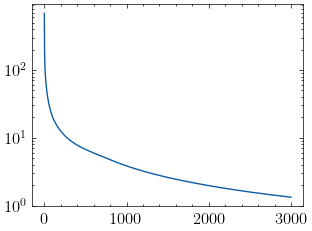

In [19]:
plt.semilogy(results[0]["history"], label="Loss")